# TensorFlow 튜토리얼 #01
# Simple Linear Model

원저자 [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ) / 번역 곽병권

## 개요

이 튜토리얼은 간단한 선형 모델로 TensorFlow를 사용하는 기본 워크플로우를 보여줍니다. 많이 알려진 MNIST 데이터 세트에 손글씨로 작성된 숫자의 이미지를 로드 한 후 TensorFlow에서 간단한 수학 모델을 정의하고 최적화합니다. 그 결과를 시각화하고 설명합니다.

기본 선형대수, 파이썬 및 Jupyter Notebook 편집기에 익숙해야 합니다. 또한 머신러닝 및 분류에 대한 기본적인 지식이 있으면 많은 도움이 됩니다.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

이 문서는 Python 3.6.1 (Anaconda) 및 아래의 TensorFlow 버전을 사용하여 개발되었습니다.

In [2]:
tf.__version__

'1.3.0'

## Load Data

MNIST 데이터 세트는 약 12MB이며 주어진 경로에 파일이 없으면 자동으로 다운로드 됩니다.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


MNIST 데이터 세트를 읽어들이면 70,000개의 이미지와 각 이미지의 라벨(즉, 이미지의 분류)로 구성됩니다. 데이터 집합은 3개의 상호 배타적인 하위 집합으로 나뉩니다. 이 튜토리얼에서는 훈련 및 테스트 세트만 사용합니다.

In [4]:
print("크기:")
print("- 훈련 세트:\t\t{}".format(len(data.train.labels)))
print("- 테스트 세트:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

크기:
- 훈련 세트:		55000
- 테스트 세트:		10000
- Validation-set:	5000


### One-Hot Encoding

데이터 세트는 원 핫 (One-Hot) 인코딩으로 읽어들였습니다. 즉, 숫자형의 레이블이 존재하는 모든 종류의 수와 동일한 벡터로 변환되었음을 의미합니다. 벡터의 모든 요소는 해당 인덱스를 제외하고는 모두 0의 값을 가집니다. 예를들어, 테스트 세트의 처음 5개 이미지에 대한 One-Hot로 인코딩 된 레이블은 다음과 같습니다.

In [5]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

또한 다양한 비교와 성능 측정을 위해 클래스에 대한 하나의 숫자가 필요하므로 가장 높은 요소의 인덱스를 사용하여 One-Hot 인코딩 된 벡터를 단일 숫자로 변환합니다. 'class'라는 단어는 파이썬에서 사용되는 키워드이므로 'cls'라는 이름을 사용했습니다.

In [6]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

이제 테스트 세트의 처음 5 개 이미지에 대한 클래스를 볼 수 있습니다. 위의 One-Hot 인코딩 된 벡터와 비교하십시오. 예를 들어, 첫 번째 이미지의 클래스는 7이며, 인덱스가 7인 요소를 제외하고 모든 요소가 0인 One-Hot 인코딩 된 벡터에 해당합니다.

In [7]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

### Data dimensions

데이터 차원은 아래 소스 코드의 여러 위치에서 사용됩니다. 컴퓨터 프로그래밍에서 일반적으로 숫자가 사용될 때마다 특정 숫자를 하드 코딩하지 않고 변수와 상수를 사용하는 것이 가장 좋습니다. 즉, 숫자는 한 곳에서 변경해야 합니다. 이상적으로는 읽은 데이터로부터 알아낼수도 있지만 여기서는 편의상 숫자를 직접 기술하였습니다.

In [8]:
# MNIST이미지는 28x28 이미지 입니다.
img_size = 28

# 이미지는 28x28의 일차원 배열로 표현합니다.
img_size_flat = img_size * img_size

# 넓이와 높이로 구성된 튜플을 이용해서 배열을 재구성합니다.
img_shape = (img_size, img_size)

# 클래스의 수는 10개이고 클래스는 0~9까지의 숫자를 나타냅니다.
num_classes = 10

### 이미지를 그리기 위한 도움 함수

3x3그리드에 9개의 이미지를 플롯하고 각 이미지 아래에 참 및 예측 클래스를 쓰는 데 사용되는 함수입니다.

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

### 일부 이미지를 화면에 그려봅니다.

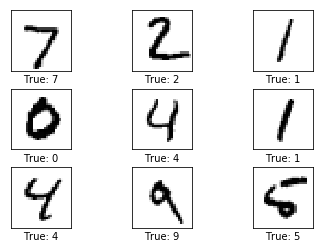

In [10]:
# 훈련용 데이터의 일부 전반부 데이터를 얻습니다.
images = data.test.images[0:9]

# 해당 이미지의 참 값을 얻어옵니다.
cls_true = data.test.cls[0:9]

# 위에서 선언한 함수를 이용하여 이미지와 참 값을 표시합니다.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

TensorFlow의 목적은 동일한 계산이 파이썬에서 직접 수행되는 것보다 훨씬 효율적으로 실행될 수있는 소위 연산 그래프를 구성하는 것입니다. TensorFlow는 실행해야 하는 전체 연산 그래프를 알고 있기 때문에 NumPy보다 더 효율적입니다. NumPy는 한 번에 하나의 수학 연산 만 계산합니다.

또한 TensorFlow는 그래프의 변수를 최적화하여 모델의 성능을 향상시키는 데 필요한 그래디언트를 자동으로 계산할 수 있습니다. 이것은 그래프가 간단한 수학적 표현의 조합이기 때문에 전체 그래프의 그래디언트가 미분에 대한 체인 규칙을 사용하여 계산 될 수 있기 때문입니다.

TensorFlow는 GPU뿐 아니라 멀티 코어 CPU를 활용할 수도 있습니다. Google은 TPU (Tensor Processing Units)라고 불리는 TensorFlow 용 특수 칩을 구축했으며 GPU보다 훨씬 빠릅니다.

TensorFlow 그래프는 아래에 설명 된 다음 부분으로 구성됩니다.

* Placeholder 변수: 변경되는 값을 입력으로 사용할 수 있도록 합니다.
* 모델 변수: 모델이 더 좋은 성능을 내도록 최적화 할 수 있습니다.
* 모델은 본질적으로 Placeholder 변수와 모델 변수의 입력이 제공되면 출력을 계산하는 수학 함수입니다.
* 비용: 변수들을 최적화 하기 위해서 사용되는 측정값 입니다.
* 최적화 기법: 모델의 변수를 변경합니다.

또한 TensorFlow 그래프는 다양한 디버깅 문을 포함할 수 있습니다. 이 노트북에서는 다루지 않지만 TensorBoard를 사용하여 데이터를 표시하도록 로그를 기록합니다.

### Placeholder 변수

Placeholder 변수는 그래프를 실행할 때 마다 그래프에 주어질 입력의 값을 변경할 수 있도록 도와주는 변수입니다. 우리는 이것을 placeholder에 공급한다고 하며, 아래 코드에서 사용법을 확인할 수 있습니다.

먼저 입력 이미지를 위한 Placeholder 변수를 정의합니다. 이러한 방법을 통해서 TensorFlow 그래프에 입력되는 이미지를 변경할 수 있습니다. 이러한 것들을 일명 텐서 (tensor)라고 부르는데, 이들은 모두 다차원 벡터 또는 행렬이라는 것을 의미합니다. 데이터 형은 `float32`로 설정되고 형태는`[None, img_size_flat]`으로 설정됩니다. 여기서`None`은 텐서가 임의의 수의 이미지를 보유 할 수 있음을 의미합니다. 각 이미지는 길이가 `img_size_flat`인 벡터입니다. .

In [11]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

다음으로 우리는 Placeholder 변수`x`에 입력 된 이미지와 관련된 실제 레이블에 대한 placeholder 변수를 선언합니다. 이 Placeholder 변수의 모양은`[None, num_classes]`입니다. 이는 임의의 수의 레이블을 보유 할 수 있음을 의미하며 각 레이블은 이 경우에는 길이가 num_classes 인 벡터입니다.

In [12]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

마지막으로 각 이미지의 실제 클래스에 대한 placeholder가 placeholder 변수 'x'에 있습니다. 이것들은 정수이고, 이 placeholder 변수의 차원은`[None]`으로 설정됩니다. 이는 placeholder 변수가 임의 길이의 1 차원 벡터임을 의미합니다.

In [13]:
y_true_cls = tf.placeholder(tf.int64, [None])

### 최적화 되어야 할 변수들

정의된 모델에 데이터를 공급하는 역할을 하는 Placeholder변수 외에, TensorFlow가 반드시 변경해야 하는, 모델 변수라는 것이 있습니다. 이러한 변경을 통해서 모델이 학습 데이터에 대해서 더 잘 예측하게 만들 수 있습니다.

최적화되어야 하는 첫 번째 변수는 `weights`라고 불리우며 TensorFlow 변수로 정의됩니다. TensorFlow 변수는 0으로 초기화 되어야 하며 모양은`[img_size_flat, num_classes]`이어야 하므로 2차원 텐서 (또는 행렬)이고 `img_size_flat`행과 `num_classes` 열이 있습니다.

In [14]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

최적화되어야 하는 두 번째 변수는 `bias`이라고 불리우며 길이가 `num_classes`인 1차원 텐서 또는 벡터로 정의됩니다.

In [15]:
biases = tf.Variable(tf.zeros([num_classes]))

### 모델

여기서 사용 할 수학 모델은 `placeholder` 변수 `x`의 이미지에 `weights`를 곱한 다음 `bias`를 더합니다.

결과는 형태가 `[num_images, num_classes]`인 행렬이 됩니다. `x`의 형태가 `[num_images, img_size_flat]`이고 `weights`는 형태가 `[img_size_flat, num_classes]`이기 때문에 두 행렬의 곱셈은 `[num_images, num_classes]` 모양을 가진 행렬을 만들고 그 행렬에 `biases` 벡터를 더하게 됩니다.

`logits`라는 이름은 일반적인 TensorFlow 용어이지만, 다른 사람들은 그 변수를 다른 것으로 부를 수도 있습니다.

In [16]:
logits = tf.matmul(x, weights) + biases

이제 `logits`는 `num_images`행과 `num_classes`열이 있는 행렬입니다. $i$'번째 행과 $j$'번째 열의 요소는 $i$'번째 입력 이미지가 $j$'번째의 클래스가 될 예상 가능성을 나타냅니다.

그러나 이러한 추정치는 숫자가 매우 작거나 커서 해석하기가 어렵습니다. 이를 정규화하여 `logits` 행렬의 각 행이 하나가 되고, 각 요소가 0과 1사이의 값이 되도록 합니다. 이것은 softmax 함수를 사용하여 계산되며 결과는 `y_pred`에 저장됩니다.

In [17]:
y_pred = tf.nn.softmax(logits)

예상값 클래스 번호는 `y_pred`행렬을 계산해서 얻을 수 있는데, 각 행의 가장 큰 항목의 색인값을 구해서 사용하면 됩니다.

In [18]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost-function 최적화하기

모델이 입력 이미지를 더 잘 분류하도록 만들려면 `weights`와 `biases`변수를 어떻게 든 변경해야 합니다. 이를 위해 우리는 모델 `y_pred`의 예측 된 출력을 원하는 출력 `y_true`와 비교하여 모델이 현재 얼마나 잘 수행되는지를 알아야 합니다.

교차 엔트로피는 분류에 사용되는 성능 측정 값입니다. 교차 엔트로피는 항상 양의 연속 함수이며 모델의 예측 된 출력이 원하는 출력과 정확히 일치하면 교차 엔트로피는 0입니다. 그러므로 최적화의 목표는 교차 엔트로피를 최소화하여 모델의 `weights`와 `bias`을 변경하여 최대한 0에 가까워지도록 하는 것입니다.

TensorFlow에는 교차 엔트로피 계산을 위한 내장 함수가 있습니다. 내부적으로 softmax를 계산하기 때문에 `logits`의 값을 사용합니다.

In [19]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

이제 각각의 이미지 분류에 대한 교차 엔트로피를 계산 했으므로 모델이 각 이미지에 대해 얼마나 잘 작동하는지 측정 할 수 있습니다. 그러나 교차 엔트로피를 사용하여 모델 변수의 최적화를 유도하려면 단일 스칼라 값이 필요하므로 모든 이미지 분류에 대해 교차 엔트로피의 평균을 취합니다.

In [20]:
cost = tf.reduce_mean(cross_entropy)

### 최적화 방법

비용을 알고 있으므로 이를 최소화하는 최적화 도구를 만들 수 있습니다. 아래의 코드는 학습률이 0.5로 설정된 경사 하강의 기본 형식입니다.

이 시점에서 최적화는 수행되지 않습니다. 사실, 아무것도 계산되지 않습니다. 나중에 실행을 위해 TensorFlow 그래프에 옵티마이저 개체를 추가하기만 하면 됩니다.

In [21]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### 성능 측정

사용자에게 진행 상황을 표시하기 위해 몇 가지 성능 측정 방법이 필요합니다.

예측 된 클래스가 각 이미지의 실제 클래스와 같은지 여부는 불린 (boolean)의 벡터입니다.

In [22]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

이것은 부울 값의 벡터를 부동 소수점 형으로 캐스팅하여 False가 0이되고 True가 1이되도록 분류 정확도를 계산 한 다음이 수의 평균을 계산합니다.

In [23]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow 실행

### TensorFlow session 만들기

TensorFlow 그래프가 생성되면 그래프를 실행하는 데 사용되는 TensorFlow 세션을 만들어야합니다.

In [24]:
session = tf.Session()

### 변수 초기화하기

`weights`와 `biases`의 변수는 최적화를 시작하기 전에 초기화되어야합니다.

In [25]:
session.run(tf.global_variables_initializer())

### 최적화 반복을 수행하는 도움 함수(Helper function)

훈련 세트에는 50.000 개의 이미지가 있습니다. 이 모든 이미지를 사용하여 모델의 그래디언트를 계산하는 데 시간이 오래 걸립니다. 따라서 우리는 최적화 기법 중에서 작은 배치 이미지세트 만을 사용하는 확률적 경사하강법(SGD)을 사용합니다.

In [26]:
batch_size = 100

점진적으로 모델의 `weights`(가중치)와 `bias`(편향)를 향상시키기 위해 여러 최적화 반복을 수행하는 기능입니다. 각 반복에서 훈련 세트에서 새로운 데이터 배치를 선택한 다음 TensorFlow는 이러한 훈련 샘플을 사용하여 최적화 프로그램을 실행합니다.


In [27]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # 훈련을 위한 배치를 선정합니다.
        # x_batch는 이미지 배치를 저장하고
        # y_true_batch 해당 이미지의 참 라벨을 저장합니다.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # 배치를 딕셔너리 형태로 해당 이름을 포함하여 바꿉니다.
        # TensorFlow 그래프의 placeholder에 사용하기 위해서 입니다.
        # y_true_cls를 위한 placeholder는 훈련에 사용되지 않습니다.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # 준비된 배치를 이용하여 최적화를 실행합니다.
        # TensorFlows는 feed_dict_train을 placeholder 변수에
        # 할당하고 최적화를 실행합니다.
        session.run(optimizer, feed_dict=feed_dict_train)

### 성능을 표시하는 도움 함수

TensorFlow 그래프의 입력으로 사용될 테스트 세트 데이터가 있는 Dict입니다. TensorFlow 그래프의 placeholder 변수에 올바른 이름을 사용해야합니다.

In [28]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

테스트 세트에 분류 정확도를 인쇄하는 함수입니다.

In [29]:
def print_accuracy():
    # 정확도를 계산하기 위해서 TensorFlow를 사용
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # 정확도를 출력
    print("Accuracy on test-set: {0:.1%}".format(acc))

scikit-learn을 사용하여 confusion 행렬을 인쇄하고 그려주는 함수입니다.

In [30]:
def print_confusion_matrix():
    # 테스트 집합에서 참 분류값을 얻습니다.
    cls_true = data.test.cls
    
    # 테스트 집합에 대한 예측 분류 값을 얻습니다.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # sklearn을 이용해서 confusion matrix를 얻습니다.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # confusion matrix를 텍스트 형태로 출력합니다.
    print(cm)

    # confusion matrix를 image 형태로 출력합니다.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Chart 옵션을 변경합니다.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

잘못 분류 된 테스트 세트의 이미지 예제를 그려주는 함수입니다.

In [31]:
def plot_example_errors():
    # TensorFlow를 이용하여 테스트 이미지가 정확히 분류 되었는지에 
    # 대한 참값의 list를 얻고, 
    # 각각의 이미지에 대한 예측된 클래스 목록을 얻습니다.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # 참 값 목록을 반전시킵니다.
    incorrect = (correct == False)
    
    # 테스트 집합에서 잘못 분류된 이미지들을 구합니다.
    images = data.test.images[incorrect]
    
    # 해당 이미지에 대한 예측값을 구합니다.
    cls_pred = cls_pred[incorrect]

    # 해당 이미지에 대한 참 값을 구합니다.
    cls_true = data.test.cls[incorrect]
    
    # 첫 9개의 이미지를 표시합니다.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### 모델 가중치를 그리기 위한 도움 함수

모델의 `weights`(가중치)를 그려주는 함수입니다. 모델이 인식하도록 훈련 된 각 숫자에 대해 하나씩 10 개의 이미지가 그려집니다.

In [32]:
def plot_weights():
    # TensorFlow에서 weights의 값을 구해옵니다.
    w = session.run(weights)
    
    # Weights에서 최소값과 최고값을 찾아냅니다.
    # 이 값을 이용하여 이미지 전체에 포함된 색의 강도를 결정하고
    # 각각의 이미지가 비교 될 수 있도록 할 것 입니다.
    w_min = np.min(w)
    w_max = np.max(w)

    # 그림은 3x4 형태의 세부 그림으로 나눌 것이며,
    # 마지막 2개은 사용하지 않습니다.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # 처음 10개의 그림을 위한 weights만 사용합니다.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            # i번째 숫자의 weights를 구한 뒤에 형태를 바꾸어 줍니다.
            # 원래의 w.shape = (image_size_flat, 10) 입니다.
            image = w[:, i].reshape(img_shape)

            # 개별 그림에 대한 라벨을 설정합니다.
            ax.set_xlabel("Weights: {0}".format(i))

            # 이미지를 그려줍니다.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # 각각의 세부 그림에서 가로 세로 눈금을 제거합니다.
        ax.set_xticks([])
        ax.set_yticks([])

## 최적화 이전의 성능

테스트 세트의 정확도는 9.8 %입니다. 이는 모델이 초기화되고 전혀 최적화되지 않았기 때문입니다. 아래 그림에서 볼 수 있듯이 이미지가 0인 경우, 예측값도 0이므로 이미지중 0인 이미지의 갯수가 9.8%라는 것을 알 수 있습니다.

In [33]:
print_accuracy()

Accuracy on test-set: 9.8%


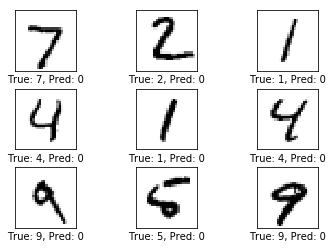

In [34]:
plot_example_errors()

## 1회의 최적화 수행 후의 성능

이미 단일 최적화 반복 후에 모델은 9.8 %에서 40.7 %로 테스트 세트의 정확도를 높였습니다. 이것은 아래의 몇 가지 예에서 볼 수 있듯이 이미지가 10 번 중 6 번 잘못 분류된다는 것을 의미합니다.

In [35]:
optimize(num_iterations=1)

In [36]:
print_accuracy()

Accuracy on test-set: 26.5%


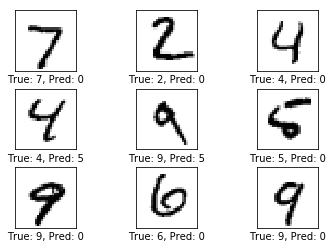

In [37]:
plot_example_errors()

다음과 같이 가중치를 그릴 수도 있습니다. 양수가 빨간색이고 음수가 파란색입니다. 이러한 가중치는 직관적으로 이미지 필터로 이해 할 수 있습니다.

예를 들어, 이미지가 영 (0) 자릿수를 나타내는 지 확인하는 데 사용되는 가중치는 원의 이미지에 대해 긍정적인(빨간색) 반응을, 원의 중심에있는 내용의 이미지에 대해 부정적인 반응(파란색)을 갖습니다.

마찬가지로 이미지가 한 자릿수를 표시하는지 확인하는 데 사용되는 가중치는 이미지의 중앙에서 수직선에 대해 긍정적(빨간색)으로 반응하고 해당 선을 둘러싸는 내용이 포함 된 이미지에는 부정적(파란색)으로 반응합니다.

가중치는 주로 인식 할 숫자와 비슷합니다. 이는 하나의 최적화 반복 만 수행되었으므로 가중치는 100 개의 이미지에 대해서만 학습되기 때문입니다. 수천 개의 이미지를 훈련 한 후에는 가중치를 쓰는 방법에 대한 많은 변형을 인식해야하기 때문에 가중치를 해석하기가 더 어려워집니다.

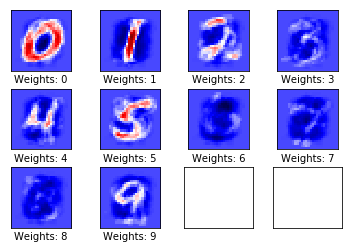

In [38]:
plot_weights()

## 10회의 최적화 반복 후의 성능

In [39]:
# 이미 1번의 최적화를 했으므로 9번만 더 하면 됩니다.
optimize(num_iterations=9)

In [40]:
print_accuracy()

Accuracy on test-set: 75.4%


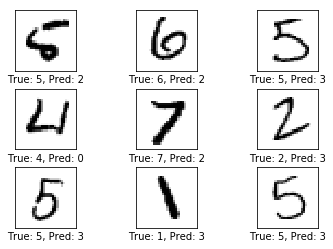

In [41]:
plot_example_errors()

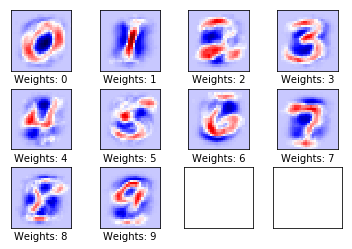

In [42]:
plot_weights()

## 1,000회의 최적화 반복 후의 성능

1000 최적화 반복 후 모델은 10개의 이미지 중 약 1개만 잘못 분류합니다. 아래에 설명 된 것처럼 이미지가 사람에게도 확실하게 판별하기가 매우 어렵거나 또는 다른 이미지가 분명하고 좋은 모델에 의해 올바르게 분류되어 있어야하기 때문에 잘못 분류 된 부분 중 일부는 정당화 됩니다. 그러나이 단순한 모델은 더 나은 성능을 낼 수 없기 때문에 더 복잡한 모델이 필요합니다.

In [43]:
# 이미 10번을 실행했으므로 990번만 하면 됩니다.
optimize(num_iterations=990)

In [44]:
print_accuracy()

Accuracy on test-set: 91.8%


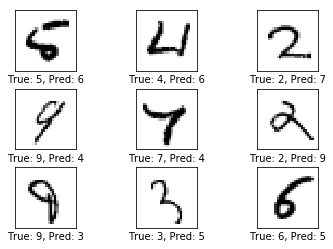

In [45]:
plot_example_errors()

이 모델은 이제 1000번의 최적화 과정을 통해 학습했고 각 반복에는 훈련 세트의 100개 이미지를 사용했습니다. 이미지의 다양성으로 인해 가중치를 해석하기가 어려워지고 모델이 선들의 구성 상황과 다양한 픽셀 변형등을 정확하게 학습했는지가 명확하지 않습니다.

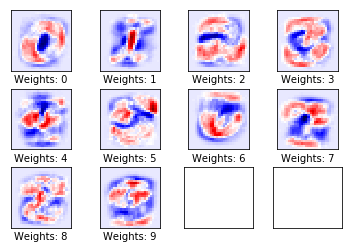

In [46]:
plot_weights()

우리는 또한 오 분류 (mis-classification)에 대한 더 자세한 정보를 볼 수 있도록 소위 혼란 매트릭스 (confusion matrix)를 인쇄하고 플롯 할 수 있습니다. 예를 들어, 5를 실제로 묘사 한 이미지가 때로는 다른 모든 가능한 숫자로 잘못 분류되었지만 대부분 3, 6 또는 8 중 하나로 분류됩니다.

[[ 958    0    2    2    0    5    7    1    5    0]
 [   0 1102    2    2    0    3    4    1   21    0]
 [   8   10  893   26   10    3   11   10   52    9]
 [   3    0    8  932    0   21    2    8   27    9]
 [   1    1    2    1  901    1   11    2   17   45]
 [  10    2    1   41    7  763   15    4   41    8]
 [  11    3    4    2   10   11  911    2    4    0]
 [   2    9   20    9    8    2    0  930    5   43]
 [   5    6    5   26    9   19   10    9  882    3]
 [   9    6    2   13   33    6    0   17   13  910]]


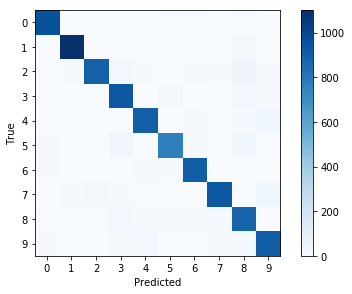

In [47]:
print_confusion_matrix()

이제 TensorFlow를 사용하여 작업을 마쳤으므로 세션을 닫아 리소스를 해제합니다.

In [48]:
# 노트북을 수정하고 실험하기를 원하는 경우를 대비해 아래 줄은 주석처리를 하였습니다.
# 노트북을 다시 시작하지 않아도 됩니다.
# session.close()

## 연습문제

TensorFlow 사용 기술을 향상 시키는데 도움이 될 수 있는 몇 가지 제안사항 입니다. TensorFlow를 제대로 사용하는 방법을 배우려면 실습 경험을 쌓는 것이 중요합니다.

변경하기 전에 이 노트북을 백업 해 두기를 추천합니다.

* 최적화 프로그램의 학습률(learning rate)을 바꿔보세요.
* 최적화 도구를 `AdagradOptimizer` 또는`AdamOptimizer`로 바꿔보세요.
* 배치 크기를 1또는 1000으로 바꿔보세요.
* 이러한 변경이 성능에 어떤 영향을 미칩니까?
* 이러한 변화가 다른 분류 문제와 수학적 모델에 대해 동일한 영향을 줄 것이라고 생각하십니까?
* 매개 변수를 변경하지 않고 노트북을 여러 번 실행하면 똑같은 결과가 나타 납니까? 그 이유는 무엇일까요?
* `plot_example_errors()`함수를 변경하여 잘못 분류 된 예제에 대한 `logits`와 `y_pred` 값을 출력합니다.
* `softmax_cross_entropy_with_logits` 대신 `sparse_softmax_cross_entropy_with_logits`를 사용하십시오. 이 경우 소스 코드를 많이 변경해야 할 수 있습니다. 두 가지 방법을 사용할 때의 장단점에 대해 토론하십시오.
* 이 소스 코드를 너무 많이 보지 않고 직접 프로그램을 다시 제작하십시오.
* 프로그램이 어떻게 작동하는지 동료에게 설명하십시오.

## 라이센스 (MIT)

저작권 (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

사용, 복사, 수정, 병합 할 수있는 권한을 포함하되 이에 국한되지 않고 소프트웨어를 취급하기 위해이 소프트웨어 및 관련 문서 파일 (이하 "소프트웨어")의 사본을 얻는 모든 사람에게 사용 권한이 무료로 부여됩니다 다음 조건에 따라 소프트웨어의 사본을 게시, 배포, 재 라이센스 또는 판매 할 수 있고 소프트웨어를 제공받는 사람에게 허용 할 수 있습니다.

위의 저작권 고지 및 이 허가 고지는 소프트웨어의 모든 사본 또는 상당 부분에 포함되어야합니다.

소프트웨어는 상품성, 특정 목적에의 적합성 및 비 침해에 대한 보증을 포함하여 (단, 이에 한하지 않음) 묵시적이든 명시적이든 어떠한 종류의 보증없이 "있는 그대로"제공됩니다. 제작자 또는 저작권 보유자는 소프트웨어 또는 사용과 관련하여 발생했거나 또는 기타 행위로 인해 발생한 청구, 기타 책임에 대해 어떠한 경우에도 책임을지지 않습니다.